# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wHAizLm_MYaUweataauffD&si=U5TXo5UgkRGc6a-F >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
import torchvision

# 3. CPU vs GPU 

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만 쓰고 있었음) 

## A. GPU 사용방법 

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [3]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

`-` gpu 연산이 가능한 메모리에 데이터 저장 

In [4]:
!nvidia-smi

Mon Apr  1 09:51:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   37C    P8              33W / 420W |     28MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

In [6]:
!nvidia-smi

Mon Apr  1 09:51:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   42C    P2             117W / 420W |    287MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> GPU에 메모리를 올리면 GPU메모리가 점유된다! (28MiB -> 287MiB) 

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인 

In [7]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]]),
 tensor([[0.0000],
         [0.2000],
         [0.4000]]),
 Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

In [8]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]], device='cuda:0'),
 tensor([[0.0000],
         [0.2000],
         [0.4000]], device='cuda:0'),
 Parameter containing:
 tensor([[-0.3467]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8470], device='cuda:0', requires_grad=True))

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함 

(예시1)

In [9]:
net_cpu(x_cpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], grad_fn=<AddmmBackward0>)

(예시2)

In [10]:
net_gpu(x_gpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], device='cuda:0', grad_fn=<AddmmBackward0>)

(예시3)

In [11]:
net_cpu(x_gpu) 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

(예시4)

In [13]:
net_gpu(x_cpu)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

(예시5)

In [14]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

tensor(1.2068, grad_fn=<MeanBackward0>)

(예시6)

In [15]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

tensor(1.2068, device='cuda:0', grad_fn=<MeanBackward0>)

(예시7)

In [16]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

(예시8)

In [17]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## B. 시간측정 (예비학습) 

In [18]:
import time 

In [19]:
t1 = time.time()

In [20]:
t2 = time.time()

In [21]:
t2-t1

0.41666603088378906

## C. CPU vs GPU (512 nodes)

`-` CPU (512 nodes) 

In [19]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.35319018363952637

`-` GPU (512 nodes) 

In [20]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.5488815307617188

- !! CPU가 더 빠르다?

## D. CPU vs GPU (20480 nodes)

`-` CPU (20480)

In [21]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

2.6340596675872803

`-` GPU (20480)

In [22]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.5354681015014648

- 왜 이런 차이가 나는가? 
- 연산을 하는 주체는 코어인데 CPU는 수는 적지만 일을 잘하는 코어들을 가지고 있고 GPU는 일은 못하지만 다수의 코어를 가지고 있기 때문 

## E. CPU vs GPU (204800 nodes)

`-` CPU (204800)

In [23]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

78.94930338859558

`-` GPU (204800)

In [24]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#--#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.3958549499511719

# 3. "확률적" 경사하강법

## A. 의문: 좀 이상하지 않아요? 

`-` 우리가 쓰는 GPU: [다나와 PC견적](http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16)

- GPU 메모리 끽해봐야 24GB

`-` 우리가 분석하는 데이터: 빅데이터..?

In [22]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

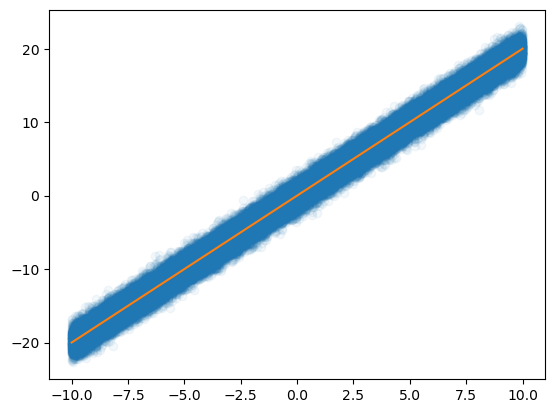

In [23]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x)

`-` 데이터의 크기가 커지는순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면 난리나겠는걸? 

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까? 

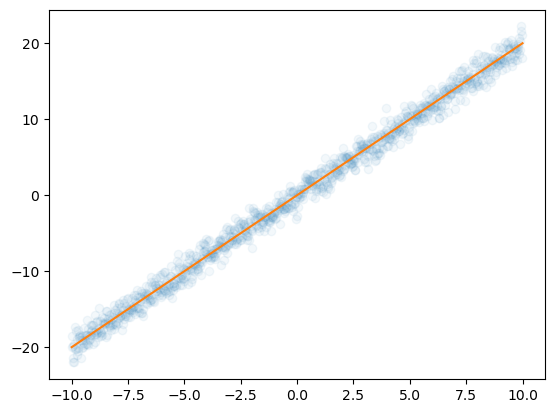

In [24]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x)

- 대충 이거만 가지고 적합해도 충분히 정확할것 같은데?

## B. X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면 안되나? 

`-` 아래의 알고리즘을 생각해보자. 

1. 데이터를 반으로 나눈다. 
2. 짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다. 
3. yhat, loss, grad, update 수행
4. 짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를 GPU메모리에 올린다. 
5. yhat, loss, grad, update 수행 
6. 홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를 GPU메모리에 올린다. 
7. 반복 

## C. 경사하강법, 확률적경사하강법, 미니배치 경사하강법 

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`-` ver1: 모든 샘플을 이용하여 slope 계산

(epoch1) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope  \to update$

(epoch2) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope  \to update$

...

> 우리가 항상 이렇게 했죠!

`-` ver2: 하나의 샘플만을 이용하여 slope 계산

(epoch1) 

- $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
- $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
- ...
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

(epoch2) 

- $loss=(y_1-w_0-w_1x_1)^2  \to slope  \to  update$
- $loss=(y_2-w_0-w_1x_2)^2  \to slope  \to  update$
- ...
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

...

`-` ver3: $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자. 

(epoch1) 

- $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

(epoch2) 

- $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

...

## D. 용어의 정리 

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent**
- https://www.deeplearningbook.org/contents/optimization.html, 알고리즘 8-1 참고.

## E. Dataset(`ds`), DataLoader(`dl`)

`-` ds

In [25]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)

In [26]:
ds=torch.utils.data.TensorDataset(x,y)
ds

In [27]:
ds.tensors 
# 그냥 ds.tensors = (x,y) 임

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

`-` dl

In [28]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
#set(dir(dl)) & {'__iter__'}

In [29]:
for xi,yi in dl:
    print(xi,yi)

tensor([[0.],
        [1.],
        [2.]]) tensor([[1.],
        [1.],
        [1.]])
tensor([[3.],
        [4.],
        [5.]]) tensor([[1.],
        [1.],
        [0.]])
tensor([[6.],
        [7.],
        [8.]]) tensor([[0.],
        [0.],
        [0.]])
tensor([[9.]]) tensor([[0.]])


## F. ds, dl을 이용한 MNIST 구현

`-` 미니배치 안쓰는 학습 

In [30]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
zero_fnames = (path/'training/0').ls()
one_fnames = (path/'training/1').ls()
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    yhat = net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
torch.sum((yhat>0.5) == y) / len(y) 

tensor(0.9981)

`-` 미니배치 쓰는 학습 

In [31]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
zero_fnames = (path/'training/0').ls()
one_fnames = (path/'training/1').ls()
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048) 
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(10):
    for xi,yi in dl: 
        ## 1
        #yihat = net(xi) <-- 쓰기 귀찮을때도 있음.. + 노테이션이 지저분함.. + 쓰기 애매할떄도 있음
        ## 2 
        loss = loss_fn(net(xi),yi) 
        ## 3 
        loss.backward() 
        ## 4 
        optimizr.step()
        optimizr.zero_grad()
## Step4: Predict 
torch.sum((net(X)>0) == y) / len(y) 

tensor(0.9951)

`-` 미니배치 쓰는 학습 + GPU도 활용

In [32]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
zero_fnames = (path/'training/0').ls()
one_fnames = (path/'training/1').ls()
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048) 
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
).to("cuda:0")
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(10):
    for xi,yi in dl: 
        ## 1
        #yihat = net(xi) <-- 쓰기 귀찮을때도 있음.. + 노테이션이 지저분함.. + 쓰기 애매할떄도 있음
        ## 2 
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3 
        loss.backward() 
        ## 4 
        optimizr.step()
        optimizr.zero_grad()
## Step4: Predict 
net.to("cpu")
torch.sum((net(X)>0) == y) / len(y) 

tensor(0.9951)

`-` 질문: 위의 "미니배치를 쓰는 학습"에서 총 몇번의 반복으로 가중치를 업데이트 할까? 

# 4. CNN 다중클래스 분류

## A. 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: sig $\to$ softmax 

***파이토치 한정*** 

- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함) 

## B. 실습: 3개의 클래스를 구분 

`-` 정리된 코드1: 통계잘하는데 파이토치 못쓰는 사람의 코드 

In [33]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    yhat = net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
softmax = torch.nn.Softmax()
#net(X).argmax(axis=1) == yhat 

In [34]:
(net(X).argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.9793)

`-` 정리된 코드2: 파이토치를 잘하는 사람의 코드 

In [35]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
#y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    yhat = net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
softmax = torch.nn.Softmax()
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9793)

## C. Softmax 

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각 observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가 있음. 

In [36]:
net(X) # 이전예제의 결과

tensor([[ 3.6941, -3.7892, -3.3333],
        [ 1.3807, -2.7186,  0.2011],
        [ 5.0991, -6.4073, -0.9572],
        ...,
        [-0.8254, -0.5244,  0.4326],
        [-1.9080, -0.1876,  0.3984],
        [-1.3289, -2.0007,  4.5881]], grad_fn=<AddmmBackward0>)

In [37]:
y # y의 라벨

tensor([0, 0, 0,  ..., 2, 2, 2])

`-` 수식 

- $\text{sig}(u)=\frac{e^u}{1+e^u}$
- $\text{sft}({\boldsymbol u})=\text{sft}([u_1,u_2,\dots,u_k])=\big[ \frac{e^{u_1}}{e^{u_1}+\dots e^{u_k}},\dots,\frac{e^{u_k}}{e^{u_1}+\dots e^{u_k}}\big]$

`-` torch.nn.Softmax() 손계산 

(예시1) -- 잘못계산 

In [38]:
sftmax = torch.nn.Softmax(dim=0)

In [39]:
netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [40]:
sftmax(netout) 

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) -- 이게 맞게 계산되는 것임 

In [41]:
sftmax = torch.nn.Softmax(dim=1)

In [42]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [43]:
sftmax(netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) -- 차원을 명시안하면 맞게 계산해주고 경고 줌 

In [44]:
sftmax = torch.nn.Softmax()

In [45]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [46]:
sftmax(netout)

/home/cgb3/anaconda3/envs/dl2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) -- 진짜 손계산 

In [47]:
netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [48]:
torch.exp(netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [49]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [50]:
torch.exp(netout[1])/torch.exp(netout[1]).sum() # 두번째 obs 

tensor([0.3333, 0.3333, 0.3333])

## D. CrossEntropyLoss

`-` 수식 

***`# 2개의 카테고리`***

`-` 예제1: BCELoss vs BCEWithLogisticLoss

In [51]:
y = torch.tensor([0,0,1]).reshape(-1,1).float()
netout = torch.tensor([-1, 0, 1]).reshape(-1,1).float()
y,netout

(tensor([[0.],
         [0.],
         [1.]]),
 tensor([[-1.],
         [ 0.],
         [ 1.]]))

In [55]:
# 계산방법1: 공식암기
sig = torch.nn.Sigmoid()
yhat = sig(netout)
-torch.mean(torch.log(yhat)*y + torch.log(1-yhat)*(1-y))

tensor(0.4399)

In [56]:
# 계산방법2: torch.nn.BCELoss() 이용
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.BCELoss()
loss_fn(sig(netout),y)

tensor(0.4399)

In [57]:
# 계산방법3: torch.nn.BCEWithLogitsLoss() 이용
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(netout,y)

tensor(0.4399)

`-` 예제2: BCEWithLogisticLoss vs CrossEntropyLoss

In [58]:
netout = torch.tensor([[1,0],[0,0],[0,1]]).float()
y = torch.tensor([[1,0],[1,0],[0,1]]).float()
y,netout #,netout[:,[1]]-netout[:,[0]]

(tensor([[1., 0.],
         [1., 0.],
         [0., 1.]]),
 tensor([[1., 0.],
         [0., 0.],
         [0., 1.]]))

In [59]:
# 계산방법1: torch.nn.CrossEntropyLoss() 이용 + y는 one-hot으로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.4399)

In [60]:
# 계산방법2: 공식암기
yhat = softmax(netout)
-torch.sum(torch.log(yhat)*y)/3

/home/cgb3/anaconda3/envs/dl2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0.4399)

In [61]:
# 계산방법3: torch.nn.CrossEntropyLoss() 이용 + y는 0,1 로 정리
y = y[:,-1].long() 
netout, y

(tensor([[1., 0.],
         [0., 0.],
         [0., 1.]]),
 tensor([0, 0, 1]))

In [62]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.4399)

`#`

***`# 3개의 카테고리`***

In [63]:
y = torch.tensor([2,1,2,2,0])
y_onehot = torch.nn.functional.one_hot(y)
netout = torch.tensor(
    [[-2.0000, -2.0000,  0.0000],
     [ 3.1400,  3.1400,  3.1400],
     [ 0.0000,  0.0000,  2.0000],
     [ 2.0000,  2.0000,  4.0000],
     [ 0.0000,  0.0000,  0.0000]]
)
y,y_onehot

(tensor([2, 1, 2, 2, 0]),
 tensor([[0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [1, 0, 0]]))

In [64]:
## 방법1 -- 추천X
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y_onehot.float())

tensor(0.5832)

In [65]:
## 방법2 -- 추천O
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.5832)

In [66]:
## 방법3 -- 공식.. (이걸 쓰는사람은 없겠지?)
sft = torch.nn.Softmax()
loss_fn = torch.nn.CrossEntropyLoss()
- torch.sum(torch.log(sft(netout))*y_onehot)/5

tensor(0.5832)

`#`

`-` 계산하는 공식을 아는것도 중요한데 torch.nn.CrossEntropyLoss() 에는 softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함. 

`-` torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss() 정도로 바꾸는 것이 더 말이 되는 것 같다. 

## E. Minor Topic: 이진분류와 CrossEntropy

`-` 2개의 클래스일경우에도 CrossEntropy를 쓸 수 있지 않을까? 

In [67]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    ## 2 
    loss= loss_fn(net(X),y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
softmax = torch.nn.Softmax()
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9983)

`-` 이진분류문제 = "y=0 or y=1" 을 맞추는 문제 = 성공과 실패를 맞추는 문제 = 성공확률과 실패확률을 추정하는 문제 

`-` softmax, sigmoid

- softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는 실패확률과 성공확률을 둘다 추정한다. 
- sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만 추정한다. 

`-` 그런데 "실패확률=1-성공확률" 이므로 사실상 둘은 같은걸 추정하는 셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까) 

`-` 즉 아래는 같은 표현력을 가진 모형이다. 

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-53-output-1.svg)

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-54-output-1.svg)

`-` 둘은 같은 표현력을 가진 모형인데 학습할 파라메터는 sigmoid의 경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함. 

- softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이 불가능한 반면 softmax는 확장이 용이하다는 장점이 있음.

## F. 정리 

`-` 결론 

1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (그냥 좀 비효율적인 느낌이 드는 것 뿐임. 흑백이미지를 칼라잉크로 출력하는 느낌) 

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Identity)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

# A1. 자잘한 용어 정리 ($\star$)

## A. 지도학습 

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다. 

1.  데이터는 $(X,y)$의 형태로 정리되어 있다. 

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는 것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|  $X$ = 설명변수 = 독립변수   | $y$ = 반응변수 = 종속변수  |     비고     |     순서     |           예시           |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|            이미지            |          카테고리          | 합성곱신경망 |   상관없음   |  개/고양이 이미지 구분   |
|         유저,아이템          |            평점            |  추천시스템  |   상관없음   |    넷플릭스 영화추천     |
|     과거~오늘까지의주가      |          내일주가          |  순환신경망  | 순서상관있음 |         주가예측         |
| 처음 $m$개의 단어(혹은 문장) | 이후 1개의 단어(혹은 문장) |  순환신경망  | 순서상관있음 |     챗봇, 텍스트생성     |
| 처음 $m$개의 단어(혹은 문장) |          카테고리          |  순환신경망  | 순서상관있음 | 영화리뷰 텍스트 감정분류 |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를 supervised learning 이라한다. 

## B. DNN, ANN, MLP

`-` DNN 은 깊은 신경망, ANN 은 인공신경망, MLP 는 다층퍼셉트론이라 번역된다.

`-` 아래의 네트워크는 ANN이라 볼 수 있다. 하지만 MLP, DNN 이라 볼 수는 없다. 

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 아래의 네트워크는 ANN이라 볼 수 있다. 또한 레이어가 2개 있으므로 MLP라고 볼 수 있다. DNN 이라 보기는 애매하다. (그래서 이걸 얕은신경망(shallow network)이라고 표현하기도 합니다)

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 아래의 네트워크는 ANN이라 볼 수 있다. 또한 레이어가 7개 있으므로 MLP라고 볼 수 있다. 이 정도면 깊어보이니까 DNN 이라 주장할 수 있어보인다. 

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid(),    
)
```

`-` 아래의 네트워크는 ANN이라 볼 수 있다. 또한 레이어가 3개 있으므로 MLP라고 볼 수 있다. 이건 DNN이라고 봐야하나? 깊다기 보다는 넓은 신경망인데... 

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1),
    torch.nn.Sigmoid(),    
)
```

`-` 야매개념: 요즘은 거의 ANN $\approx$ MLP $\approx$ DNN 의 느낌으로 쓴다. 

- 어지간한 모형은 다 ANN이라 우길 수 있다. 회귀분석도, 로지스틱분석도 마음먹으면 ANN으로 우길 수 있다. 그래서 ANN을 썼다라는건 뭘 썼는지 모르겟다는 말이랑 같다. 이런 이유로 사람들은 거의 MLP를 쓴 경우에 ANN을 썼다고 하고, 회귀모형을 쓴 경우에는 굳이 ANN을 썼다고 표현하지 않는다. 
- MLP과 DNN은 구분이 모호하다. 하나이상의 은닉층만 포함하고 있으면 MLP라고 부를 수 있다. 적은 노드수를 유지하면서 은닉층을 여러개 쓰면 깊은신경망이라고 하고, 많은 노드를 사용하면서 은닉층을 얇게, 그리고 노드를 많이 쓰면 넓은신경망이라고 한다. 얼마나 깊을때 DNN으로 부를지 명확한 합의가 되어있지 않다. (3층-MLP부터 DNN으로 부르는 방식이 지지를 얻는듯. 그렇지만 4층-MLP 부터 DNN으로 부르는 사람도 존재함.)
- 이러한 이유로 거의 ANN, MLP, DNN은 비슷한 뉘앙스로 사용된다. 

## C 학습이란? 

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 "함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘 찾는 것이다. (이 경우 "함수를 추정한다"라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “모델” 혹은 "모형"을 찾는 것이다. 즉 $y\approx model(X)$가 되도록 만드는 $model$을 잘 찾는 것이다. (이 경우 "모형을 학습시킨다"라고 표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록 만드는 $net$을 잘 찾는 것이다. (이 경우 "네트워크를 학습시킨다"라고 표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여 $\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는 $f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## D. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에 따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

`-` 경우1은 “$loss$ = $y$ 와 $\hat{y}$ 의 차이” 를 정의할 수 있으나 경우2는 그렇지 않다.

## E. 다양한 코드들 


`-` 파이썬 코드..

```Python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
learner.learn() # fastai 에서 "학습"을 의미하는 과정
learner.fine_tune(1) # fastai 에서 "부분학습"을 의미하는 과정
learner.predict(cat1) # fastai 에서 "예측"을 의미하는 과정 
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정 
```

`-` R 코드..

```r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력 
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```


# A2. 참고자료들 

`-` 케라스/텐서플로우: <https://guebin.github.io/STBDA2022/>

`-` 상속: <https://guebin.github.io/PP2023/posts/03_Class/2023-06-12-15wk-1.html>

`-` sklearn/autogluon: <https://guebin.github.io/MP2023/>

`-` 리눅스관련: <https://guebin.github.io/DSTBX2024/> -- 자료 부실함.. 강의영상 없는것 많음.. 